In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.6 MB/s eta 0:00:00


In [3]:
# pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.6 MB/s eta 0:00:00


In [4]:
import os
import random
import pickle
import gc
import warnings
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import (
    StandardScaler, PowerTransformer, OrdinalEncoder,
    OneHotEncoder, FunctionTransformer, PolynomialFeatures, LabelEncoder
)
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import (
    LogisticRegression, LinearRegression, Ridge, Lasso,
    SGDRegressor, ElasticNet
)
from sklearn.model_selection import (
    train_test_split, cross_val_score, cross_validate,
    GridSearchCV, KFold, cross_val_predict
)
from sklearn.metrics import (
    roc_auc_score, mean_squared_error, make_scorer, accuracy_score, log_loss
)
from sklearn import set_config, datasets
from catboost import (
    CatBoostRegressor, CatBoostClassifier
)
from sklearn.pipeline import (
    Pipeline, FeatureUnion, make_pipeline
)
from sklearn.ensemble import (
    RandomForestClassifier, StackingClassifier, StackingRegressor,
    GradientBoostingRegressor, VotingClassifier, VotingRegressor,
    HistGradientBoostingRegressor, GradientBoostingClassifier,
    BaggingClassifier, AdaBoostClassifier, RandomForestRegressor,ExtraTreesRegressor
)

from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.svm import SVC, SVR, LinearSVC
from xgboost import XGBRegressor, XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons

import xgboost as xgb
import lightgbm as lgb
import re
import optuna
import math
from pandas.errors import DataError
from scipy.stats import zscore

%matplotlib inline

warnings.filterwarnings("ignore")

In [5]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
seed_everything(42)

In [6]:
#데이터 로드
train = pd.read_csv("/content/drive/MyDrive/3-2/머신러닝/dacon/고객 대출등급 분류 해커톤/train.csv")
test = pd.read_csv("/content/drive/MyDrive/3-2/머신러닝/dacon/고객 대출등급 분류 해커톤/test.csv")

# #데이터 로드
# train = pd.read_csv("train.csv")
# test = pd.read_csv("test.csv")

In [7]:
#전처리
def pre_all(train, test):
    print(f"전처리 전 train 크기 : {train.shape}")
    print(f"전처리 전 test 크기 : {test.shape}")
    print("=================전처리 중=================")

    df = pd.concat([train,test]).reset_index(drop = True)


    df['근로기간'] = df['근로기간'].replace({
        '10+ years' : '10',
        '2 years' : '2',
        '< 1 year' : '1',
        '3 years' : '3',
        '1 year' : '1',
        'Unknown' : '12',
        '5 years' : '5',
        '4 years' : '4',
        '8 years' : '8',
        '6 years' : '6',
        '7 years' : '7',
        '9 years' : '9',
        '10+years': '10',
        '<1 year' : '1',
        '1 years' : '1'
    })
    df['근로기간'] = df['근로기간'].astype('int64')

    #대출기간 전처리
    def preprocess_loan_term(term):
        if pd.isnull(term):
            return None
        else:
            return int(term.replace(' months', '').strip())
    df['대출기간'] = df['대출기간'].apply(preprocess_loan_term)

    train = df[~df["대출등급"].isnull()].sort_values("ID").reset_index(drop = True)
    test = df[df["대출등급"].isnull()].sort_values("ID").reset_index(drop=True)
    test = test.drop(columns=["대출등급"])

    print(f"전처리 후 train 크기 : {train.shape}")
    print(f"전처리 후 test 크기 : {test.shape}")

    return train, test

train_pre, test_pre = pre_all(train, test)

전처리 전 train 크기 : (96294, 15)
전처리 전 test 크기 : (64197, 14)
=================전처리 중=================
전처리 후 train 크기 : (96294, 15)
전처리 후 test 크기 : (64197, 14)


In [8]:
label_encoder = LabelEncoder()
train_pre.대출등급= label_encoder.fit_transform(train.대출등급)

# 총상환원금

In [9]:
train_pre['상환여부'] = (train_pre['총상환원금'] + train_pre['총상환이자'] > 0).astype(int)
train_pre['상환여부_원금'] = (train_pre['총상환원금'] > 0).astype(int)
train_pre['상환여부_이자'] = (train_pre['총상환이자'] > 0).astype(int)

test_pre['상환여부'] = (test_pre['총상환원금'] + test_pre['총상환이자'] > 0).astype(int)
test_pre['상환여부_원금'] = (test_pre['총상환원금'] > 0).astype(int)
test_pre['상환여부_이자'] = (test_pre['총상환이자'] > 0).astype(int)

#OHE
cat = ['주택소유상태','대출목적']
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe.fit(train_pre[cat])
columns = []
for i, c in enumerate(cat):
    columns += [f'{c}_{v}' for v in ohe.categories_[i]]
# 생성된 dummy를 DataFrame으로 변환
df_ohe = pd.DataFrame(ohe.transform(train_pre[cat]), columns=columns)
# 인코딩한 feature는 제거하고 나머지 feature와 결합
train_pre= pd.concat([train_pre.drop(columns=cat).reset_index(drop=True), df_ohe], axis=1) # 원래 피처 삭제 후 OHE된 feature 병합

columns = []
for i, c in enumerate(cat):
    columns += [f'{c}_{v}' for v in ohe.categories_[i]]
# 생성된 dummy를 DataFrame으로 변환
df_ohe = pd.DataFrame(ohe.transform(test_pre[cat]), columns=columns)
# 인코딩한 feature는 제거하고 나머지 feature와 결합
test_pre= pd.concat([test_pre.drop(columns=cat).reset_index(drop=True), df_ohe], axis=1) # 원래 피처 삭제 후 OHE된 feature 병합



In [10]:
근로기간_train = train_pre[train_pre['근로기간'] != 12]
근로기간_test= train_pre[train_pre['근로기간'] == 12]

In [ ]:
# from pycaret.classification import *
# x_train, x_test, y_train, y_test = train_test_split(근로기간_train.drop(columns=["ID"]), 근로기간_train['근로기간'])
# exp_clf = setup(data=x_train, target='근로기간', session_id=123 ,  use_gpu=True)

# best_model = compare_models()

In [11]:
def objective(trial):
    x_train, x_test, y_train, y_test = train_test_split(
        근로기간_train.drop('근로기간', axis=1),
        근로기간_train['근로기간'],
        test_size=0.3,
        random_state=42
    )

    # Change ExtraTreesRegressor to AdaBoostClassifier
    classifier = AdaBoostClassifier(
        n_estimators=trial.suggest_int('n_estimators', 50, 500),
        learning_rate=trial.suggest_loguniform('learning_rate', 0.001, 1.0),
        algorithm=trial.suggest_categorical('algorithm', ['SAMME', 'SAMME.R']),
        random_state=42
    )

    classifier.fit(x_train.drop(columns=['ID']), y_train.drop(columns=['ID']))
    y_pred = classifier.predict(x_test.drop(columns=['ID']))

    # Use accuracy as the metric (you may adjust based on your specific requirements)
    accuracy = accuracy_score(y_test.drop(columns=['ID']), y_pred)

    return 1 - accuracy  # Minimize the error rate

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

adaboost_best_params_근로기간 = study.best_params
print(f"최적 하이퍼파라미터: {adaboost_best_params_근로기간}")


[I 2024-02-02 04:56:58,889] A new study created in memory with name: no-name-a79becaf-4e6c-4633-ae07-a212fba5ef17
[I 2024-02-02 04:57:30,727] Trial 0 finished with value: 0.6353404200537021 and parameters: {'n_estimators': 52, 'learning_rate': 0.25283975689807814, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.6353404200537021.
[I 2024-02-02 04:58:34,455] Trial 1 finished with value: 0.6347519034832825 and parameters: {'n_estimators': 292, 'learning_rate': 0.004996882868239982, 'algorithm': 'SAMME'}. Best is trial 1 with value: 0.6347519034832825.
[I 2024-02-02 04:59:15,069] Trial 2 finished with value: 0.6460808474638614 and parameters: {'n_estimators': 380, 'learning_rate': 0.0014915582688123652, 'algorithm': 'SAMME.R'}. Best is trial 1 with value: 0.6347519034832825.
[I 2024-02-02 05:00:02,084] Trial 3 finished with value: 0.6326553132011623 and parameters: {'n_estimators': 438, 'learning_rate': 0.21839141511364094, 'algorithm': 'SAMME.R'}. Best is trial 3 with value: 0.632655

최적 하이퍼파라미터: {'n_estimators': 385, 'learning_rate': 0.4096541005881881, 'algorithm': 'SAMME.R'}


In [12]:
근로기간_test.drop(columns= ['근로기간'], inplace= True)

ada_classification_근로기간 = AdaBoostClassifier(**adaboost_best_params_근로기간)
ada_classification_근로기간.fit(근로기간_train.drop(['ID','근로기간','대출등급'], axis=1), 근로기간_train['근로기간'])

근로기간_test['근로기간'] = ada_classification_근로기간.predict(근로기간_test.drop(columns=['ID','대출등급']))

train_pre = pd.concat([근로기간_train, 근로기간_test], axis=0)

train_pre = train_pre.sort_values(by='ID')

In [13]:
원금_train = train_pre[train_pre['상환여부_원금'] != 0]
원금_test= train_pre[train_pre['상환여부_원금'] == 0]

In [14]:
def objective(trial):

    x_train, x_test, y_train, y_test = train_test_split(
        원금_train.drop('총상환원금', axis=1),
        원금_train['총상환원금'],
        test_size=0.3,
        random_state=42
    )

    regressor = ExtraTreesRegressor(
        n_estimators=trial.suggest_int('n_estimators', 50, 500),
        max_depth=trial.suggest_int('max_depth', 3, 20),
        min_samples_split=trial.suggest_float('min_samples_split', 0.1, 1.0),
        min_samples_leaf=trial.suggest_float('min_samples_leaf', 0.1, 0.5),
        max_features=trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        random_state=42
    )

    regressor.fit(x_train.drop(columns = ['ID']), y_train.drop(columns = ['ID']))
    y_pred = regressor.predict(x_test.drop(columns = ['ID']))
    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(y_test.drop(columns = ['ID']), y_pred))

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40)

et_best_params_원금 = study.best_params
print(f"최적 하이퍼파라미터: {et_best_params_원금}")

[I 2024-02-02 05:17:03,687] A new study created in memory with name: no-name-3cc839c0-610e-4363-8e9d-6724e5a346b0
[I 2024-02-02 05:17:05,123] Trial 0 finished with value: 985340.6042928292 and parameters: {'n_estimators': 340, 'max_depth': 7, 'min_samples_split': 0.8280270177740388, 'min_samples_leaf': 0.3544196288416567, 'max_features': 'sqrt'}. Best is trial 0 with value: 985340.6042928292.
[I 2024-02-02 05:17:05,704] Trial 1 finished with value: 985760.1675167395 and parameters: {'n_estimators': 142, 'max_depth': 19, 'min_samples_split': 0.24363673055601365, 'min_samples_leaf': 0.3451060447532698, 'max_features': 'sqrt'}. Best is trial 0 with value: 985340.6042928292.
[I 2024-02-02 05:17:07,613] Trial 2 finished with value: 975466.851685234 and parameters: {'n_estimators': 371, 'max_depth': 5, 'min_samples_split': 0.19661033048527907, 'min_samples_leaf': 0.18493001832910833, 'max_features': 'log2'}. Best is trial 2 with value: 975466.851685234.
[I 2024-02-02 05:17:09,321] Trial 3 fi

최적 하이퍼파라미터: {'n_estimators': 384, 'max_depth': 14, 'min_samples_split': 0.18646594963858604, 'min_samples_leaf': 0.13363127107447031, 'max_features': 'auto'}


In [15]:
원금_test.drop(columns= ['총상환원금'], inplace= True)

from sklearn.ensemble import ExtraTreesRegressor
et_regressor_원금 = ExtraTreesRegressor(**et_best_params_원금)
et_regressor_원금.fit(원금_train.drop(['ID','총상환원금','대출등급'], axis=1), 원금_train['총상환원금'])

원금_test['총상환원금'] = et_regressor_원금.predict(원금_test.drop(columns=['ID','대출등급']))

In [16]:
train_pre = pd.concat([원금_train, 원금_test], axis=0)

In [17]:
train_pre = train_pre.sort_values(by='ID')

In [18]:
이자_train = train_pre[train_pre['상환여부_이자'] != 0]
이자_test= train_pre[train_pre['상환여부_이자'] == 0]

In [19]:
def objective(trial):

    x_train, x_test, y_train, y_test = train_test_split(
        이자_train.drop(['ID','총상환이자'], axis=1),
        이자_train['총상환이자'],
        test_size=0.3,
        random_state=42
    )

    regressor = ExtraTreesRegressor(
        n_estimators=trial.suggest_int('n_estimators', 50, 500),
        max_depth=trial.suggest_int('max_depth', 3, 20),
        min_samples_split=trial.suggest_float('min_samples_split', 0.1, 1.0),
        min_samples_leaf=trial.suggest_float('min_samples_leaf', 0.1, 0.5),
        max_features=trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        random_state=42
    )

    regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)
    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40)

et_best_params_이자 = study.best_params
print(f"최적 하이퍼파라미터: {et_best_params_이자}")

[I 2024-02-02 05:22:23,451] A new study created in memory with name: no-name-8392bbe0-2f53-4279-b2ae-c381a54a6a3c
[I 2024-02-02 05:22:25,299] Trial 0 finished with value: 437998.2814872672 and parameters: {'n_estimators': 470, 'max_depth': 19, 'min_samples_split': 0.5268146345215683, 'min_samples_leaf': 0.35850143818602953, 'max_features': 'sqrt'}. Best is trial 0 with value: 437998.2814872672.
[I 2024-02-02 05:22:26,451] Trial 1 finished with value: 442130.4812926793 and parameters: {'n_estimators': 324, 'max_depth': 20, 'min_samples_split': 0.32078008850712814, 'min_samples_leaf': 0.42829528872294065, 'max_features': 'log2'}. Best is trial 0 with value: 437998.2814872672.
[I 2024-02-02 05:22:28,013] Trial 2 finished with value: 441651.03296521096 and parameters: {'n_estimators': 493, 'max_depth': 7, 'min_samples_split': 0.27085203885142894, 'min_samples_leaf': 0.3964092623872304, 'max_features': 'log2'}. Best is trial 0 with value: 437998.2814872672.
[I 2024-02-02 05:22:31,206] Trial

최적 하이퍼파라미터: {'n_estimators': 286, 'max_depth': 11, 'min_samples_split': 0.24902663956979654, 'min_samples_leaf': 0.10014692919264011, 'max_features': 'auto'}


In [20]:
이자_test.drop(columns= ['총상환이자'], inplace= True)

from sklearn.ensemble import ExtraTreesRegressor
et_regressor_이자 = ExtraTreesRegressor(**et_best_params_이자)
et_regressor_이자.fit(이자_train.drop(['ID','총상환이자','대출등급'], axis=1), 이자_train['총상환이자'])

이자_test['총상환이자'] = et_regressor_이자.predict(이자_test.drop(columns=['ID','대출등급']))

train_pre = pd.concat([이자_train, 이자_test], axis=0)
train_pre = train_pre.sort_values(by='ID')

# test 셋 적용

In [21]:
근로기간_test_test= test_pre[test_pre['근로기간'] == 12]
근로기간_test_train= test_pre[test_pre['근로기간'] != 12]
근로기간_test_test.drop(columns= ['근로기간'], inplace= True)
근로기간_test_test['근로기간'] = ada_classification_근로기간.predict(근로기간_test_test.drop(columns = ['ID']))
test_pre = pd.concat([근로기간_test_train, 근로기간_test_test], axis=0)

원금_test_test= test_pre[test_pre['상환여부_원금'] == 0]
원금_test_train= test_pre[test_pre['상환여부_원금'] != 0]
원금_test_test.drop(columns= ['총상환원금'], inplace= True)
원금_test_test['총상환원금'] = et_regressor_원금.predict(원금_test_test.drop(columns = ['ID']))
test_pre = pd.concat([원금_test_train, 원금_test_test], axis=0)

이자_test_train= test_pre[test_pre['상환여부_이자'] != 0]
이자_test_test= test_pre[test_pre['상환여부_이자'] == 0]
이자_test_test.drop(columns= ['총상환이자'], inplace= True)
이자_test_test['총상환이자'] = et_regressor_이자.predict(이자_test_test.drop(columns = ['ID']))
test_pre = pd.concat([이자_test_train, 이자_test_test], axis=0)

In [22]:
test_pre = test_pre.sort_values(by='ID')

In [23]:
#전처리
def pre_all(train, test):
    print(f"전처리 전 train 크기 : {train_pre.shape}")
    print(f"전처리 전 test 크기 : {test_pre.shape}")
    print("=================전처리 중=================")

    df = pd.concat([train_pre,test_pre]).reset_index(drop = True)

    df["월_대출금액"] = round(df["대출금액"] /df["대출기간"],1)
    df["월_대출대비_소득비율"] = round((df["연간소득"]/12)/df["월_대출금액"],1)

    df["계좌수"] =df["총계좌수"] / (df["연체계좌수"] + 1)

    df["대출금액_총상환이자_비율"] = np.where(df["총상환이자"] == 0, np.nan,df["대출금액"] /df["총상환이자"])
    df["대출금액_총상환이자_비율"].fillna(0, inplace=True)

    df["대출금액_총상환원금_비율"] = np.where(df["총상환원금"] == 0, np.nan,df["대출금액"] /df["총상환원금"])
    df["대출금액_총상환원금_비율"].fillna(0, inplace=True)

    df["상환이자_상환원금"] =df.apply(lambda x : 0 if x["총상환이자"] == x["총상환원금"] else (1 if x["총상환이자"] > x["총상환원금"] else 2), axis=1)

    # "상환여부" 피쳐 추가
    df['상환여부'] = (df['총상환원금'] + df['총상환이자'] > 0).astype(int)
    df['상환여부_원금'] = (df['총상환원금'] > 0).astype(int)
    df['상환여부_이자'] = (df['총상환이자'] > 0).astype(int)

    df["최근_2년간_연체_횟수"] =df["최근_2년간_연체_횟수"].apply(lambda x: 1 if x > 0 else 0)

    df["총상환액"] =df["총상환원금"] + df["총상환이자"]

    df["소득대비_총상환액_비율"] =df["총상환액"] /df["연간소득"]
    df["대출대비_총상환액_비율"] =df["총상환액"] /df["대출금액"]
    df["기간대비_총상환액_비율"] =df["총상환액"] /df["대출기간"]

    df["대출대비_총상환원금_비율"] =df["총상환원금"] /df["대출금액"]
    df["대출대비_총상환이자_비율"] =df["총상환이자"] /df["대출금액"]

    df["소득대비_총상환원금_비율"] =df["총상환원금"] /df["연간소득"]
    df["소득대비_총상환이자_비율"] =df["총상환이자"] /df["연간소득"]

    df["기간대비_총상환원금_비율"] =df["총상환원금"] /df["대출기간"]
    df["기간대비_총상환이자_비율"] =df["총상환이자"] /df["대출기간"]

    df["월_이자_지불액"] =df["대출금액"] *df["대출금액_총상환이자_비율"] /df["대출기간"]

    df.replace([np.inf, -np.inf], 0, inplace=True)

    df.drop(["총계좌수", "연체계좌수", "총연체금액"], axis=1, inplace=True)
    # df 분리하기
    train = df[~df["대출등급"].isnull()].reset_index(drop = True)
    test = df[df["대출등급"].isnull()].reset_index(drop=True)
    test = test.drop(columns=["대출등급"])

    print(f"전처리 후 train 크기 : {train.shape}")
    print(f"전처리 후 test 크기 : {test.shape}")

    return train, test

train_pre, test_pre = pre_all(train, test)

전처리 전 train 크기 : (96294, 32)
전처리 전 test 크기 : (64197, 31)
=================전처리 중=================
전처리 후 train 크기 : (96294, 46)
전처리 후 test 크기 : (64197, 45)


---

In [ ]:
# def outlier(df, col, z):
#     return df[abs(df[col] - np.mean(df[col]))/np.std(df[col])>z].index

# def find_z_score_indices(df, col, z_threshold):
#     z_scores = zscore(df[col])
#     z_indices = np.where(np.abs(z_scores) >= z_threshold)[0]
#     return z_indices

In [ ]:
# 연간소득_train_for_z_1 = find_z_score_indices(train_pre, '연간소득', 3)
# 총상환원금_train_for_z_1 = find_z_score_indices(train_pre, '총상환원금', 3)
# 총상환이자_train_for_z_1 = find_z_score_indices(train_pre, '총상환이자', 3)

# 연간소득_test_for_z_1 = find_z_score_indices(test_pre, '연간소득', 3)
# 총상환원금_test_for_z_1 = find_z_score_indices(test_pre, '총상환원금', 3)
# 총상환이자_test_for_z_1 = find_z_score_indices(test_pre, '총상환이자', 3)

# train_pre.loc[outlier(train, '연간소득', 3), "연간소득"] = 연간소득_train_for_z_1
# train_pre.loc[outlier(train, '총상환원금', 3), "총상환원금"] = 총상환원금_train_for_z_1
# train_pre.loc[outlier(train, '총상환이자', 3), "총상환이자"] = 총상환이자_train_for_z_1

# test_pre.loc[outlier(test, '연간소득', 3), "연간소득"] = 연간소득_test_for_z_1
# test_pre.loc[outlier(test, '총상환원금', 3), '총상환원금'] = 총상환원금_test_for_z_1
# test_pre.loc[outlier(test, '총상환이자', 3), '총상환이자'] = 총상환이자_test_for_z_1

In [24]:
target = train_pre.대출등급
train_pre = train_pre.drop(['ID',"대출등급"], axis=1)
test_pre = test_pre.drop(['ID'], axis=1)
ID_test = test.ID

# 로그화

In [25]:
train_pre['총상환원금_총상환이자_곱'] = train_pre['총상환원금'] * train_pre['총상환이자']
train_pre['총상환원금_총상환이자_뺄'] = train_pre['총상환원금'] - train_pre['총상환이자']

test_pre['총상환원금_총상환이자_곱'] = test_pre['총상환원금'] * test_pre['총상환이자']
test_pre['총상환원금_총상환이자_뺄'] = test_pre['총상환원금'] - test_pre['총상환이자']

In [ ]:
# scaler = StandardScaler()
# list_num = ['대출금액', '연간소득','총상환원금','총상환이자', '총연체금액', '월평균소득','대출금액_총상환이자','총상환원금_총상환이자']
# train_pre[list_num] = scaler.fit_transform(train_pre[list_num])
# test_pre[list_num] = scaler.transform(test_pre[list_num])
# log_train = train_pre
# log_test = test_pre

In [26]:
list_num = ['대출금액', '연간소득','총상환원금','총상환이자','월_대출금액', '상환이자_상환원금', '총상환액', '총상환원금_총상환이자_곱']
# items_to_exclude에 있는 항목을 제외한 리스트 생성
filtered_list_train = [x for x in train_pre.columns if x not in list_num]
filtered_list_test = [x for x in test_pre.columns if x not in list_num]

log_train = train_pre[list_num].apply(lambda x : np.log(x+1))
log_train = pd.concat([train_pre[filtered_list_train], log_train,], axis=1)

log_test = test_pre[list_num].apply(lambda x : np.log(x+1))
log_test = pd.concat([ test_pre[filtered_list_test],log_test], axis=1)

# LDA

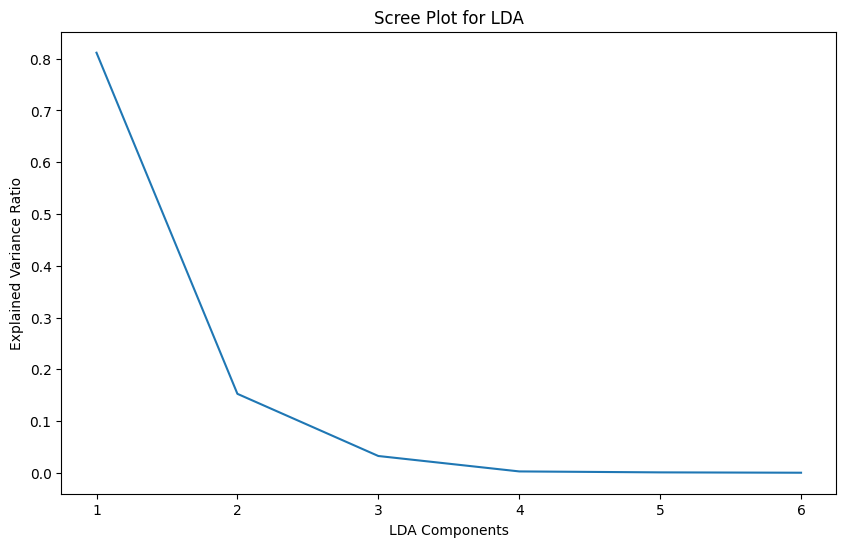

In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA()

# LDA를 훈련 데이터에 적용
lda.fit(log_train, target)
lda_transformed_train = lda.transform(log_train)

plt.figure(figsize=(10, 6))
plt.plot(range(1, lda_transformed_train.shape[1] + 1), lda.explained_variance_ratio_)
plt.xlabel('LDA Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot for LDA')
plt.show()

In [28]:
# LDA수는 가장 적합한 2로 설정해서 다시 적용
lda = LDA(n_components=2)

lda.fit(log_train, target)
lda_transformed_train = lda.transform(log_train)
lda_transformed_test = lda.transform(log_test)

# LDA로 생성된 칼럼명을 작성하기 위함
lda_columns_train = [f'LDA{i+1}' for i in range(lda_transformed_train.shape[1])]
lda_columns_test = [f'LDA{i+1}' for i in range(lda_transformed_test.shape[1])]

lda_df_train = pd.DataFrame(lda_transformed_train, columns = lda_columns_train)
lda_df_test = pd.DataFrame(lda_transformed_test, columns = lda_columns_test)

# NumPy 배열을 데이터프레임으로 변환
scaled_train = pd.DataFrame(log_train, columns=train_pre.columns, index=train_pre.index)
scaled_test = pd.DataFrame(log_test, columns=test_pre.columns, index=test_pre.index)

lda_train_x = pd.concat([scaled_train, lda_df_train], axis=1)
lda_test_x = pd.concat([scaled_test, lda_df_test], axis=1)

# smote

In [29]:
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np

# SMOTE 적용
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(lda_train_x, target)

# SMOTE 이전과 이후의 클래스 분포 확인
print("클래스 분포 (이전):", dict(zip(*np.unique(target, return_counts=True))))
print("클래스 분포 (이후):", dict(zip(*np.unique(y_resampled, return_counts=True))))


클래스 분포 (이전): {0.0: 16772, 1.0: 28817, 2.0: 27623, 3.0: 13354, 4.0: 7354, 5.0: 1954, 6.0: 420}
클래스 분포 (이후): {0.0: 28817, 1.0: 28817, 2.0: 28817, 3.0: 28817, 4.0: 28817, 5.0: 28817, 6.0: 28817}


여기서부터 X_resampled, y_resampled로 진행

# Optuna

In [30]:
# lgbm optuna
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Define the objective function for optimization
def objective(trial):
    params = {
        'objective': 'multiclass',
        'num_class': 7,
        'boosting_type': 'gbdt',
        'metric': 'multi_logloss',
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 32),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'random_state' : 42
    }


    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)
    # Make predictions on the validation set
    y_pred = model.predict(X_test)
    # F1-score 계산
    f1 = f1_score(y_test, y_pred, average='weighted')

    return f1  # Optuna는 목적 함수를 최대화하려고 시도합니다.

# Optuna 스터디 설정
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=35)

# 최적화된 매개변수 출력
lgbm_best_params = study.best_params
print(f"최적 매개변수: {lgbm_best_params}")

# 최적 매개변수로 최종 모델 훈련
best_model = LGBMClassifier(**lgbm_best_params)
best_model.fit(X_train, y_train)

# 최종 모델로 테스트 세트에 대한 예측
y_pred_final = best_model.predict(X_test)

# 최종 모델 성능 평가
f1_final = f1_score(y_test, y_pred_final, average='weighted')
print(f"최종 모델의 F1-score: {f1_final}")


[I 2024-02-02 05:29:07,140] A new study created in memory with name: no-name-a5631b48-fca0-4410-84fb-39295ce26e29


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:29:40,725] Trial 0 finished with value: 0.9514391787480836 and parameters: {'subsample': 0.7960173788475091, 'colsample_bytree': 0.7754940755635624, 'learning_rate': 0.07576083817303467, 'max_depth': 27, 'num_leaves': 35}. Best is trial 0 with value: 0.9514391787480836.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:30:18,888] Trial 1 finished with value: 0.9527044905531707 and parameters: {'subsample': 0.5081890931015095, 'colsample_bytree': 0.5998687207075932, 'learning_rate': 0.03341913498492814, 'max_depth': 21, 'num_leaves': 88}. Best is trial 1 with value: 0.9527044905531707.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:30:57,690] Trial 2 finished with value: 0.9606044924198317 and parameters: {'subsample': 0.839038390543714, 'colsample_bytree': 0.7254649524514173, 'learning_rate': 0.08025556107822633, 'max_depth': 21, 'num_leaves': 85}. Best is trial 2 with value: 0.9606044924198317.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:31:28,053] Trial 3 finished with value: 0.9539292566605504 and parameters: {'subsample': 0.9117736012601236, 'colsample_bytree': 0.6430816221711155, 'learning_rate': 0.0706094442888039, 'max_depth': 9, 'num_leaves': 53}. Best is trial 2 with value: 0.9606044924198317.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:31:56,311] Trial 4 finished with value: 0.9420798433527761 and parameters: {'subsample': 0.6825059897888825, 'colsample_bytree': 0.8639221094178547, 'learning_rate': 0.061381899004961264, 'max_depth': 18, 'num_leaves': 24}. Best is trial 2 with value: 0.9606044924198317.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2024-02-02 05:32:23,562] Trial 5 finished with value: 0.9490972383828579 and parameters: {'subsample': 0.9376509524183845, 'colsample_bytree': 0.7505494387892333, 'learning_rate': 0.09173597745903757, 'max_depth': 6, 'num_leaves': 37}. Best is trial 2 with value: 0.9606044924198317.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:32:51,010] Trial 6 finished with value: 0.9387784581556053 and parameters: {'subsample': 0.8008335877330459, 'colsample_bytree': 0.513417596927058, 'learning_rate': 0.07963190647920797, 'max_depth': 19, 'num_leaves': 16}. Best is trial 2 with value: 0.9606044924198317.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:33:28,571] Trial 7 finished with value: 0.9617176285380064 and parameters: {'subsample': 0.8162927240522784, 'colsample_bytree': 0.6735559185645827, 'learning_rate': 0.0947300823891042, 'max_depth': 18, 'num_leaves': 76}. Best is trial 7 with value: 0.9617176285380064.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:34:08,900] Trial 8 finished with value: 0.960951332834449 and parameters: {'subsample': 0.9980156403738187, 'colsample_bytree': 0.9179890894938472, 'learning_rate': 0.09508568653026855, 'max_depth': 13, 'num_leaves': 86}. Best is trial 7 with value: 0.9617176285380064.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:34:43,169] Trial 9 finished with value: 0.9519591803283275 and parameters: {'subsample': 0.7337674757026496, 'colsample_bytree': 0.6135834166595772, 'learning_rate': 0.03671544756587696, 'max_depth': 16, 'num_leaves': 75}. Best is trial 7 with value: 0.9617176285380064.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:35:19,405] Trial 10 finished with value: 0.9182213588459367 and parameters: {'subsample': 0.6393223574579444, 'colsample_bytree': 0.51274043507867, 'learning_rate': 0.003736810821615505, 'max_depth': 32, 'num_leaves': 64}. Best is trial 7 with value: 0.9617176285380064.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:36:02,931] Trial 11 finished with value: 0.9619698089121328 and parameters: {'subsample': 0.9992913914587053, 'colsample_bytree': 0.9828127930165965, 'learning_rate': 0.0997404718912089, 'max_depth': 12, 'num_leaves': 96}. Best is trial 11 with value: 0.9619698089121328.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:36:47,406] Trial 12 finished with value: 0.9619834893321796 and parameters: {'subsample': 0.9014751193731703, 'colsample_bytree': 0.9794999666321113, 'learning_rate': 0.09866910006026416, 'max_depth': 12, 'num_leaves': 97}. Best is trial 12 with value: 0.9619834893321796.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:37:30,280] Trial 13 finished with value: 0.9561348539831296 and parameters: {'subsample': 0.9921889517641911, 'colsample_bytree': 0.9963441953156356, 'learning_rate': 0.05417323728715293, 'max_depth': 11, 'num_leaves': 95}. Best is trial 12 with value: 0.9619834893321796.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2024-02-02 05:38:02,711] Trial 14 finished with value: 0.9514131976574792 and parameters: {'subsample': 0.9072762037531084, 'colsample_bytree': 0.9794477469033902, 'learning_rate': 0.09846184018013851, 'max_depth': 6, 'num_leaves': 97}. Best is trial 12 with value: 0.9619834893321796.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2024-02-02 05:38:20,845] Trial 15 finished with value: 0.8653521832664488 and parameters: {'subsample': 0.8750609443648801, 'colsample_bytree': 0.8571188397252925, 'learning_rate': 0.034308508536689056, 'max_depth': 3, 'num_leaves': 59}. Best is trial 12 with value: 0.9619834893321796.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:39:04,166] Trial 16 finished with value: 0.9213157287543511 and parameters: {'subsample': 0.9535072770819568, 'colsample_bytree': 0.9190557906554032, 'learning_rate': 0.0020298355451079386, 'max_depth': 14, 'num_leaves': 99}. Best is trial 12 with value: 0.9619834893321796.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:39:42,168] Trial 17 finished with value: 0.9586407805762245 and parameters: {'subsample': 0.8889013242192528, 'colsample_bytree': 0.835781609370543, 'learning_rate': 0.0856715275547174, 'max_depth': 9, 'num_leaves': 72}. Best is trial 12 with value: 0.9619834893321796.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:40:16,544] Trial 18 finished with value: 0.9521266325781642 and parameters: {'subsample': 0.9603557351198502, 'colsample_bytree': 0.9468020605539187, 'learning_rate': 0.06769538735190131, 'max_depth': 23, 'num_leaves': 43}. Best is trial 12 with value: 0.9619834893321796.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:40:57,001] Trial 19 finished with value: 0.9428905891877798 and parameters: {'subsample': 0.5368011252197732, 'colsample_bytree': 0.8174674982093131, 'learning_rate': 0.02122783507517502, 'max_depth': 14, 'num_leaves': 82}. Best is trial 12 with value: 0.9619834893321796.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2024-02-02 05:41:32,963] Trial 20 finished with value: 0.9447496649411377 and parameters: {'subsample': 0.7515118529110529, 'colsample_bytree': 0.9065456911733164, 'learning_rate': 0.04652261429044087, 'max_depth': 7, 'num_leaves': 67}. Best is trial 12 with value: 0.9619834893321796.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:42:09,125] Trial 21 finished with value: 0.9619745349246469 and parameters: {'subsample': 0.8450279126628855, 'colsample_bytree': 0.6903802493559179, 'learning_rate': 0.09988149831708343, 'max_depth': 16, 'num_leaves': 77}. Best is trial 12 with value: 0.9619834893321796.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:42:49,042] Trial 22 finished with value: 0.9616245214224354 and parameters: {'subsample': 0.8563030591791955, 'colsample_bytree': 0.7192585920815029, 'learning_rate': 0.09994701294202821, 'max_depth': 12, 'num_leaves': 91}. Best is trial 12 with value: 0.9619834893321796.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:43:34,244] Trial 23 finished with value: 0.962229630589604 and parameters: {'subsample': 0.9351827019578558, 'colsample_bytree': 0.9620380697686646, 'learning_rate': 0.08753700653105062, 'max_depth': 15, 'num_leaves': 100}. Best is trial 23 with value: 0.962229630589604.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:44:15,083] Trial 24 finished with value: 0.961015660173966 and parameters: {'subsample': 0.7596351383760054, 'colsample_bytree': 0.7992063184450003, 'learning_rate': 0.0884042941839372, 'max_depth': 16, 'num_leaves': 81}. Best is trial 23 with value: 0.962229630589604.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:44:53,905] Trial 25 finished with value: 0.9621181137715162 and parameters: {'subsample': 0.9232743615879782, 'colsample_bytree': 0.6899346615526138, 'learning_rate': 0.08560947869489004, 'max_depth': 24, 'num_leaves': 91}. Best is trial 23 with value: 0.962229630589604.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:45:37,376] Trial 26 finished with value: 0.9624176711378533 and parameters: {'subsample': 0.943336496433613, 'colsample_bytree': 0.5625826499722031, 'learning_rate': 0.08525380667144668, 'max_depth': 26, 'num_leaves': 99}. Best is trial 26 with value: 0.9624176711378533.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:46:19,180] Trial 27 finished with value: 0.960071317571531 and parameters: {'subsample': 0.9433894353238834, 'colsample_bytree': 0.5556918807145564, 'learning_rate': 0.06344435596215557, 'max_depth': 26, 'num_leaves': 91}. Best is trial 26 with value: 0.9624176711378533.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:47:03,340] Trial 28 finished with value: 0.9629246096249652 and parameters: {'subsample': 0.5988433038045311, 'colsample_bytree': 0.5739012533245045, 'learning_rate': 0.08429114087100556, 'max_depth': 29, 'num_leaves': 100}. Best is trial 28 with value: 0.9629246096249652.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:47:47,306] Trial 29 finished with value: 0.9615797419221586 and parameters: {'subsample': 0.6171587924855546, 'colsample_bytree': 0.5627984585786705, 'learning_rate': 0.07604210100302082, 'max_depth': 30, 'num_leaves': 100}. Best is trial 28 with value: 0.9629246096249652.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:48:21,115] Trial 30 finished with value: 0.9565298640056183 and parameters: {'subsample': 0.6264344069535531, 'colsample_bytree': 0.5891474261656343, 'learning_rate': 0.05658383439948094, 'max_depth': 28, 'num_leaves': 69}. Best is trial 28 with value: 0.9629246096249652.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:48:59,959] Trial 31 finished with value: 0.9618832586190537 and parameters: {'subsample': 0.5799781488956335, 'colsample_bytree': 0.6407583203265204, 'learning_rate': 0.0857845244811932, 'max_depth': 25, 'num_leaves': 91}. Best is trial 28 with value: 0.9629246096249652.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:49:41,445] Trial 32 finished with value: 0.9612651583015932 and parameters: {'subsample': 0.6872952087575352, 'colsample_bytree': 0.5541656851562802, 'learning_rate': 0.08175532065648469, 'max_depth': 28, 'num_leaves': 89}. Best is trial 28 with value: 0.9629246096249652.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:50:24,790] Trial 33 finished with value: 0.9615897693288852 and parameters: {'subsample': 0.5053768250591152, 'colsample_bytree': 0.7678759925619769, 'learning_rate': 0.07308595078640334, 'max_depth': 23, 'num_leaves': 100}. Best is trial 28 with value: 0.9629246096249652.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:51:02,034] Trial 34 finished with value: 0.9603839475874467 and parameters: {'subsample': 0.9625498131309846, 'colsample_bytree': 0.6281959579535517, 'learning_rate': 0.07658094391839212, 'max_depth': 30, 'num_leaves': 83}. Best is trial 28 with value: 0.9629246096249652.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:51:33,646] Trial 35 finished with value: 0.9576143784129508 and parameters: {'subsample': 0.9282036669596121, 'colsample_bytree': 0.6746747774040041, 'learning_rate': 0.0890011911965571, 'max_depth': 21, 'num_leaves': 50}. Best is trial 28 with value: 0.9629246096249652.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:52:10,847] Trial 36 finished with value: 0.9606124936325386 and parameters: {'subsample': 0.6873182667817317, 'colsample_bytree': 0.5907768700680567, 'learning_rate': 0.06714810109249139, 'max_depth': 24, 'num_leaves': 93}. Best is trial 28 with value: 0.9629246096249652.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:52:49,123] Trial 37 finished with value: 0.9617726068545488 and parameters: {'subsample': 0.8729881385270805, 'colsample_bytree': 0.7137584317530928, 'learning_rate': 0.08102157742995794, 'max_depth': 21, 'num_leaves': 87}. Best is trial 28 with value: 0.9629246096249652.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:53:18,242] Trial 38 finished with value: 0.9503777060611435 and parameters: {'subsample': 0.7873475018006304, 'colsample_bytree': 0.535746324743296, 'learning_rate': 0.09132798609378705, 'max_depth': 32, 'num_leaves': 27}. Best is trial 28 with value: 0.9629246096249652.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846


[I 2024-02-02 05:53:54,997] Trial 39 finished with value: 0.9613686921778462 and parameters: {'subsample': 0.7204618843664904, 'colsample_bytree': 0.6491348663405981, 'learning_rate': 0.08333012206488763, 'max_depth': 28, 'num_leaves': 81}. Best is trial 28 with value: 0.9629246096249652.


최적 매개변수: {'subsample': 0.5988433038045311, 'colsample_bytree': 0.5739012533245045, 'learning_rate': 0.08429114087100556, 'max_depth': 29, 'num_leaves': 100}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 44
[LightGBM] [Info] Start training from score -1.942340
[LightGBM] [Info] Start training from score -1.944120
[LightGBM] [Info] Start training from score -1.947590
[LightGBM] [Info] Start training from score -1.943972
[LightGBM] [Info] Start training from score -1.947292
[LightGBM] [Info] Start training from score -1.954266
[LightGBM] [Info] Start training from score -1.941846
최종 모델의 F1-score: 0.96297527910

In [31]:
#XGB optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import optuna
from sklearn.metrics import f1_score
# 목표 변수 라벨 인코딩
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Optuna 최적화를 위한 목적 함수 정의
def objective(trial):
    params = {
        'objective': 'multi:softprob',
        'num_class': 7,
        'booster': 'gbtree',
        'eval_metric': 'mlogloss',
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'random_state' : 42
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train_encoded)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test_encoded, y_pred, average='weighted')

    return f1

# Optuna 스터디 설정
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 35)

# 최적화된 매개변수 출력
xgb_best_params = study.best_params
print(f"최적 매개변수: {xgb_best_params}")

# 최적 매개변수로 최종 모델 훈련
best_model = xgb.XGBClassifier(**xgb_best_params)
best_model.fit(X_train, y_train_encoded)

# 최종 모델로 테스트 세트에 대한 예측
y_pred_final = best_model.predict(X_test)

# 예측 결과 디코딩
y_pred_final_decoded = label_encoder.inverse_transform(y_pred_final)

# 최종 모델 성능 평가
f1_final = f1_score(y_test, y_pred_final_decoded, average='weighted')
print(f"최종 모델의 F1-score: {f1_final}")


[I 2024-02-02 05:54:40,117] A new study created in memory with name: no-name-c57389f4-25e2-4558-8aa1-b73869f7c32b
[I 2024-02-02 05:55:00,975] Trial 0 finished with value: 0.8645092720277783 and parameters: {'subsample': 0.23891469982910865, 'colsample_bytree': 0.38041759076104775, 'learning_rate': 0.06177859246360965, 'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.631610426211008}. Best is trial 0 with value: 0.8645092720277783.
[I 2024-02-02 05:55:24,490] Trial 1 finished with value: 0.8804390483175595 and parameters: {'subsample': 0.4662630358384211, 'colsample_bytree': 0.5839087267166049, 'learning_rate': 0.0783844874358352, 'max_depth': 3, 'min_child_weight': 14, 'gamma': 0.5951462512487322}. Best is trial 1 with value: 0.8804390483175595.
[I 2024-02-02 05:56:30,253] Trial 2 finished with value: 0.9276445494167391 and parameters: {'subsample': 0.6593063305187347, 'colsample_bytree': 0.8321936071710094, 'learning_rate': 0.006144516436716631, 'max_depth': 17, 'min_child_weight': 1

최적 매개변수: {'subsample': 0.7874269301851476, 'colsample_bytree': 0.8279953910591581, 'learning_rate': 0.08355746968362396, 'max_depth': 18, 'min_child_weight': 2, 'gamma': 0.6147593160647901}
최종 모델의 F1-score: 0.9619246519771174


# shap

In [32]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 3.9 MB/s eta 0:00:00


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10304
[LightGBM] [Info] Number of data points in the train set: 201719, number of used features: 44
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910


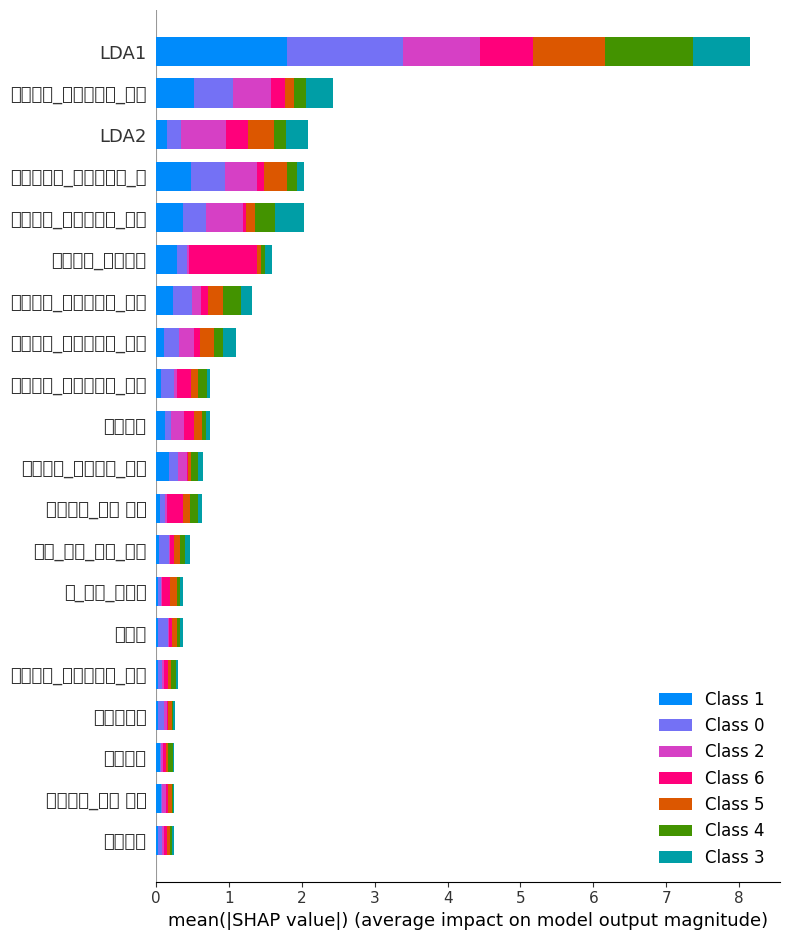

,column_name,shap_importance
46,LDA1,1.800554
31,대출금액_총상환원금_비율,0.524065
45,총상환원금_총상환이자_뺄,0.476742
37,대출대비_총상환원금_비율,0.36779
32,상환이자_상환원금,0.283522
38,대출대비_총상환이자_비율,0.225561
35,대출대비_총상환액_비율,0.179281
47,LDA2,0.146024
1,대출기간,0.120139
30,대출금액_총상환이자_비율,0.103417


In [33]:
# FEATURE SELECTION
import shap
X_importance = lda_test_x

model = LGBMClassifier(**lgbm_best_params).fit(X_resampled, y_resampled)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

shap.summary_plot(shap_values, X_importance, plot_type='bar')

shap_sum = np.abs(shap_values).mean(axis=1)[1,:]
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

In [34]:
# 지정된(SHAP_THRESHOLD) Shap feature 중요도 이상인 것만 선택
SHAP_THRESHOLD = 0.001
features_selected = importance_df.query('shap_importance > @SHAP_THRESHOLD').column_name.tolist()
X_resampled = X_resampled[features_selected]
lda_test_x = lda_test_x[features_selected]

In [35]:
xgb_clf = xgb.XGBClassifier(**xgb_best_params)
lgbm_clf = LGBMClassifier(**lgbm_best_params)
vote_model_clf = VotingClassifier(
    estimators=[("lgbm", lgbm_clf), ("xgb", xgb_clf)],
    voting='soft'
)

# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_resampled)

vote_model_clf.fit(X_resampled, y_resampled)
y_pred = vote_model_clf.predict(lda_test_x)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9474
[LightGBM] [Info] Number of data points in the train set: 201719, number of used features: 40
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910


In [36]:
label_encoder = LabelEncoder()
label_encoder.fit(train['대출등급'])  # y_train은 훈련 데이터의 실제 클래스 레이블

LabelEncoder()

In [37]:
y_pred_original = label_encoder.inverse_transform(y_pred.astype(int))
print(y_pred_original)

['B' 'C' 'A' ... 'D' 'C' 'A']


In [38]:
t = pd.Timestamp.now()
fname = f"voting_submission_{t.month:02}월{t.day:02}일{t.hour:02}시{t.minute:02}분.csv"
pd.DataFrame({'ID': ID_test, '대출등급': y_pred_original}).to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")

'voting_submission_02월02일07시14분.csv' is ready to submit.
